## Dubendorf Meeting (12.11.2025)

In [235]:
# imports
import pandas as pd
import numpy as np
import xarray as xr
import dolfyn as dlfn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import re
from glob import glob
from tqdm.notebook import tqdm
import warnings; warnings.filterwarnings('ignore')

### Field Work Campaign

In [236]:
# Lake Zug bathymetry
bathy = xr.open_dataset('../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

#### Mooring Deployment

In [237]:
mooring_locs = pd.DataFrame({
    'loc': ['LZC', 'LZE', 'LZW', 'LZN'],
    'xsc_plan': [2680090, 2680328, 2679884, 2679423],
    'ysc_plan': [1218816, 1218866, 1218764, 1219382],
    'xsc': [2680084, 2680314, 2679912, 2679436],
    'ysc': [1218840, 1218883, 1218770, 1219384]
})

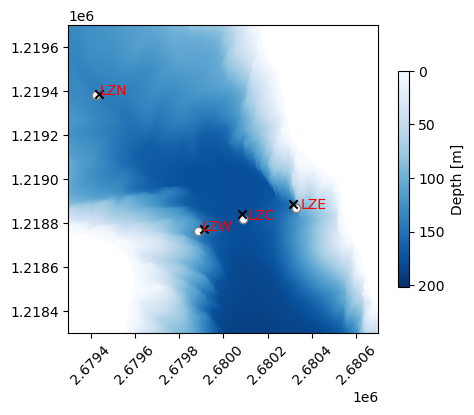

In [238]:
fig, ax = plt.subplots(figsize=(5, 4))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

for _, row in mooring_locs.iterrows():
    # planned locations
    ax.scatter(row.xsc_plan, row.ysc_plan, c='white', edgecolor='gray')
    ax.annotate(row['loc'], (row.xsc_plan, row.ysc_plan), color='red', xytext=(3, 0), textcoords='offset points')

    # deployed locations
    ax.scatter(row.xsc, row.ysc, c='black', marker='x')

ax.tick_params(axis='x', rotation=45)
ax.set_xlim(2679300, 2680700)
ax.set_ylim(1218300, 1219700)

plt.savefig('../gallery/dd/2025_12_11/moorings.png', bbox_inches='tight')
plt.show()

#### CTD Transects

In [239]:
# planned locations
profile_locs = pd.DataFrame({
    'loc': [f'P{x}' for x in range(1, 13)],
    'xsc': [679803, 679803, 679663, 679415, 679505, 680030, 680150, 680223, 680409, 680814, 681350, 681909],
    'ysc': [224100, 222690, 221650, 220433, 219544, 218872, 218462, 218126, 217437, 216239, 214957, 213760]
})
profile_locs['xsc'] += int(2e6)
profile_locs['ysc'] += int(1e6)

profile_locs['depth'] = [bathy.sel(xsc=row.xsc, ysc=row.ysc).depth.item() for _, row in profile_locs.iterrows()]

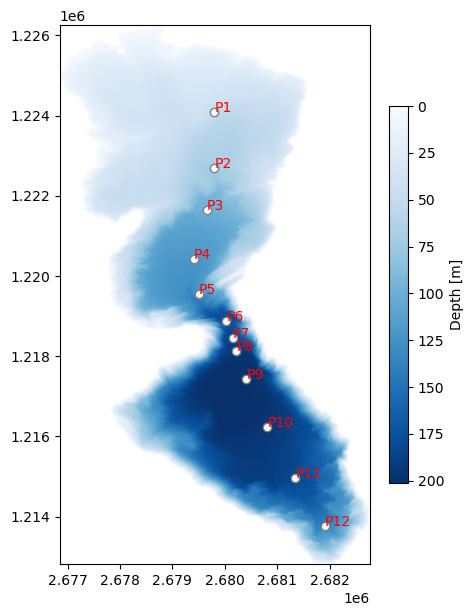

In [240]:
fig, ax = plt.subplots(figsize=(5, 7))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

# planned locations
for _, row in profile_locs.iterrows():
    ax.scatter(row.xsc, row.ysc, c='white', edgecolor='gray')
    ax.annotate(row['loc'], (row.xsc, row.ysc), color='red')

plt.savefig('../gallery/dd/2025_12_11/ctd.png', bbox_inches='tight')
plt.show()

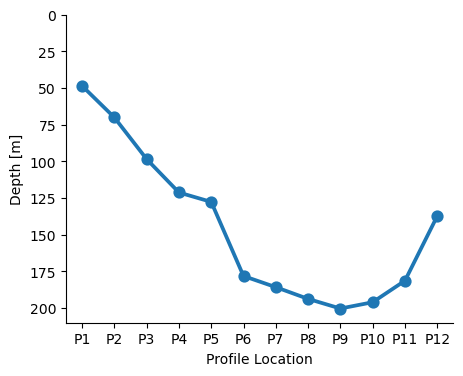

In [241]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.pointplot(profile_locs, x='loc', y='depth', ax=ax)

ax.set_xlabel('Profile Location')
ax.set_ylabel('Depth [m]')
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(0, 210)
ax.invert_yaxis()

plt.savefig('../gallery/dd/2025_12_11/ctd_depth.png', bbox_inches='tight')
plt.show()

### Oxygen Overturnings

In [242]:
def parse_metadata(md_file, location):
    md = pd.read_csv(md_file, sep='\t')[f'Mooring: {location}']

    # deployment and retrieval dates
    deploy_mask = md.str.startswith('Deployment').fillna(False)
    retrieve_mask = md.str.startswith('Retrieval').fillna(False)
    dt_deploy = datetime.strptime(md.loc[deploy_mask].iloc[0].split()[-1], "%d/%m/%Y")
    dt_retrieve = datetime.strptime(md.loc[retrieve_mask].iloc[0].split()[-1], "%d/%m/%Y")

    # Switzerland coordinates
    lon_mask = md.str.startswith('Longitude').fillna(False)
    lat_mask = md.str.startswith('Latitude').fillna(False)
    xsc = int(md.loc[lon_mask].iloc[0].split()[-1]) + int(2e6)
    ysc = int(md.loc[lat_mask].iloc[0].split()[-1]) + int(1e6)

    # total depth of mooring/lake at location
    total_depth = int(re.search(r'\d+', pd.read_csv(md_file, sep='\t').iloc[0][f'Mooring: {location}']).group())

    return {'dt_deploy': dt_deploy, 
            'dt_retrieve': dt_retrieve,
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth}


def create_depth_map(md_file, total_depth):
    depth_map = pd.read_csv(md_file, sep='\t', names=['instrument', 'serial_id', 'mab', 'comments']).dropna(subset=('serial_id'))[1:].reset_index(drop=True)
    depth_map['mab'] = depth_map['mab'].astype(float)
    depth_map['depth'] = total_depth - depth_map['mab']
    
    return depth_map


def load_oxygen_data(data_dir, serial_id, depth_map):
    # file path to concatenated file with all days' data
    fpath = os.path.join(data_dir, f'7450-{serial_id}/Cat.TXT')

    # handle leading '0' in serial_id
    if serial_id != str(int(serial_id)):
        serial_id = str(int(serial_id))

    # read from .txt
    with open(fpath, 'r') as f:
        lines = [x[:-1] for x in f if len(x.split(',')) > 1]

    # extract column names and units
    cols = [x.lstrip(' ') for x in lines[0].split(',')]
    units = [x.lstrip(' ') for x in lines[1].split(',')]
    cols_units = [f'{c} {u}' for c, u in zip(cols, units)]

    data = []
    for line in lines[2:]:
        data.append((x.lstrip(' ') for x in line.split(',')))

    # store in dataframe
    data = pd.DataFrame(data, columns=cols_units)
    data['Unix Timestamp (Second)'] = data['Unix Timestamp (Second)'].astype(int)           # already in chronological order
    data['Temperature (deg C)'] = data['Temperature (deg C)'].astype(float)
    data['Dissolved Oxygen (mg/l)'] = data['Dissolved Oxygen (mg/l)'].astype(float)
    data['Dissolved Oxygen Saturation (%)'] = data['Dissolved Oxygen Saturation (%)'].astype(float)
    data['UTC_Date_&_Time (none)'] = pd.to_datetime(data['UTC_Date_&_Time (none)'])
    data['depth'] = depth_map.query('serial_id == @serial_id').iloc[0]['depth']

    return data


# calculate number of overturns, time length of overturns, and difference in o2 during overturns
# PME MiniDOT brochure says accuracy 0.3 mg/l
def calculate_overturn_time_intensity(d_low, d_comp, accuracy=0.3):
    mask = d_low > d_comp

    data = []
    prior = mask.values[0]
    for i in tqdm(range(1, len(mask))):
        current = mask.values[i]

        # start of overturning
        if current and not prior:
            t_start = mask['UTC_Date_&_Time (none)'][i].item()
            max_intensity = d_low.values[i] - d_comp.values[i]
            j = i + 1

            # time length and max intensity of overturning
            while mask[j]:
                intensity = d_low.values[j] - d_comp.values[j]
                if intensity > max_intensity:
                    max_intensity = intensity
                j += 1
            t_end = mask['UTC_Date_&_Time (none)'][j].item()

            data.append({'d_low': d_low.depth.item(), 'd_comp': d_comp.depth.item(), 
                        't_len': (t_end - t_start) / 1e9, 'intensity': max_intensity,
                        'acc1': max_intensity > accuracy, 'acc2': max_intensity > 2*accuracy})

        prior = current

    return pd.DataFrame(data)

In [256]:
lake = 'Zugersee'
location = 'LZ1'
year = '2025'
date = '20250424'

data_dir = f'Q:/Messdaten/Aphys_hypothesis_data/{lake}/{year}/Mooring/{date}/{location}/'
md_file = f'Q:/Messdaten/Aphys_hypothesis_data/{lake}/{year}/Mooring/{date}/{date}_{location}_meta.tsv'
oxygen_loggers = [os.path.join(data_dir, o) for o in glob('7450-*', root_dir=data_dir)]

In [258]:
md = parse_metadata(md_file, location)
depth_map = create_depth_map(md_file, md['total_depth'])
md

{'dt_deploy': datetime.datetime(2025, 1, 16, 0, 0),
 'dt_retrieve': datetime.datetime(2025, 4, 24, 0, 0),
 'xsc': 2680186,
 'ysc': 1281332,
 'total_depth': 187}

In [259]:
oxygen_data = []
for o in tqdm(oxygen_loggers):
    serial_id = os.path.basename(o).split('-')[-1]
    data = load_oxygen_data(data_dir, serial_id, depth_map)

    # remove downcast and upcast     # TO DO: find optimal boundaries
    dt_min = data['UTC_Date_&_Time (none)'].min()
    dt_max = data['UTC_Date_&_Time (none)'].max()
    dt_start = dt_min + pd.Timedelta(hours=168)
    dt_end = dt_max - pd.Timedelta(hours=12)
    data = data[data['UTC_Date_&_Time (none)'].between(dt_start, dt_end)]

    data['serial_id'] = serial_id
    oxygen_data.append(data)

oxygen_data = pd.concat(oxygen_data, ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

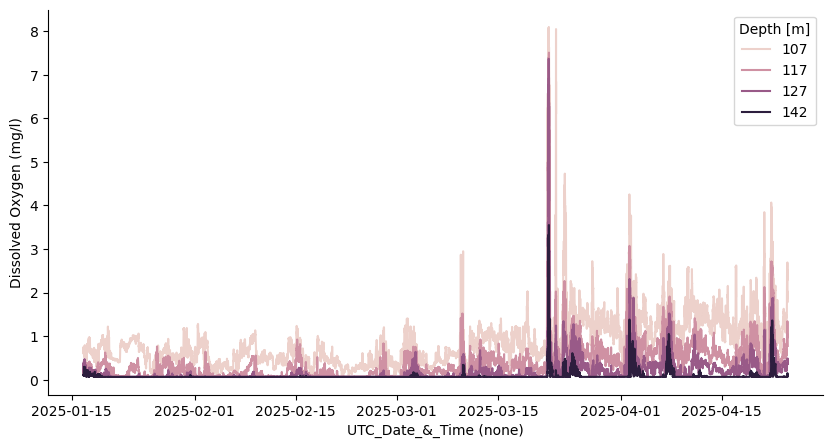

In [260]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(oxygen_data, x='UTC_Date_&_Time (none)', y='Dissolved Oxygen (mg/l)', hue='depth', ax=ax)

ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
labels = [int(float(x)) for x in labels]
ax.legend(handles, labels, title='Depth [m]')

plt.savefig('../gallery/dd/2025_12_11/o2_ts.png', bbox_inches='tight')
plt.show()

In [261]:
# timeseries of deepest oxygen logger
o2_ts = oxygen_data.query('depth == 142')['Dissolved Oxygen (mg/l)'].to_numpy()

# index of global maximum
o2_max_dt = oxygen_data.query('depth == 142').iloc[o2_ts.argmax()]['UTC_Date_&_Time (none)']

# oxyen data following global maximum
oxygen_data_post_gmax = oxygen_data[oxygen_data['UTC_Date_&_Time (none)'] >= o2_max_dt]

# timeseries of deepest oxygen logger following global maximum
o2_ts_post_gmax = oxygen_data_post_gmax.query('depth == 142')['Dissolved Oxygen (mg/l)'].to_numpy()

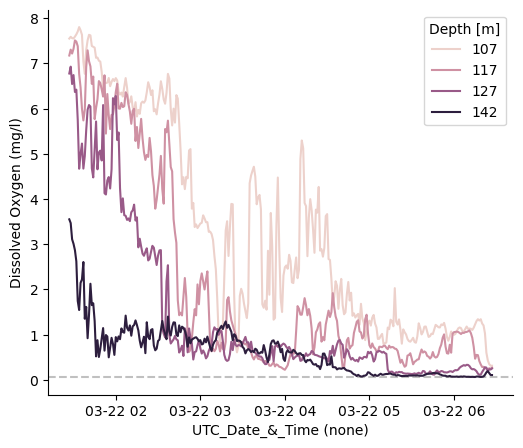

In [262]:
# zoom in on post max decrease
fig, ax = plt.subplots(figsize=(6, 5))

ax.axhline(o2_ts_post_gmax.min(), color='silver', ls='--')
sns.lineplot(oxygen_data_post_gmax[oxygen_data_post_gmax['UTC_Date_&_Time (none)'] <= o2_max_dt + pd.Timedelta(hours=5)], 
             x='UTC_Date_&_Time (none)', y='Dissolved Oxygen (mg/l)', hue='depth', ax=ax)

ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
labels = [int(float(x)) for x in labels]
ax.legend(handles, labels, title='Depth [m]')

plt.savefig('../gallery/dd/2025_12_11/o2_postmax.png', bbox_inches='tight')
plt.show()

In [263]:
# convert to xarray dataset
ds = oxygen_data.sort_values(['depth', 'UTC_Date_&_Time (none)']).set_index(['UTC_Date_&_Time (none)', 'depth']).to_xarray()
ds = ds.assign_coords(serial_id=('depth', oxygen_data.drop_duplicates('depth')['serial_id'].values))

In [264]:
overturn_data = []
d_low = ds.sel(depth=142)['Dissolved Oxygen (mg/l)']
for d in [127, 117, 107]:
    d_comp = ds.sel(depth=d)['Dissolved Oxygen (mg/l)']
    overturn_data.append(calculate_overturn_time_intensity(d_low, d_comp))

overturn_data = pd.concat(overturn_data, ignore_index=True)

  0%|          | 0/140454 [00:00<?, ?it/s]

  0%|          | 0/140454 [00:00<?, ?it/s]

  0%|          | 0/140454 [00:00<?, ?it/s]

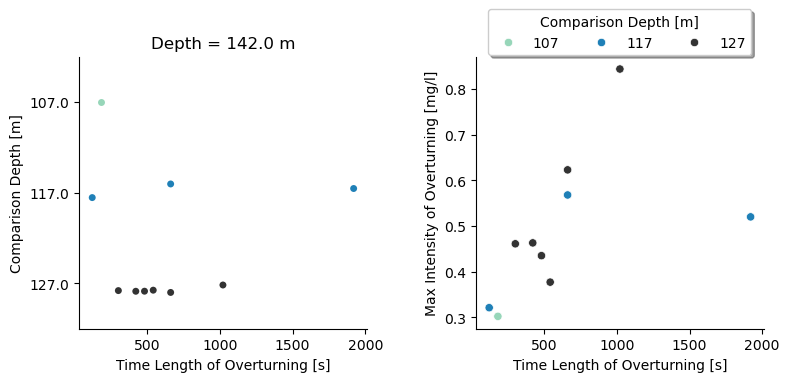

In [265]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True)

# time length of overturnings as a function of depth
# overturnings intensity > accuracy
sns.stripplot(overturn_data[overturn_data['acc1']], x='t_len', y='d_comp', orient='y', hue='d_comp', palette='YlGnBu_d', ax=ax[0], legend=False)

ax[0].set_xlabel('Time Length of Overturning [s]')
ax[0].set_ylabel('Comparison Depth [m]')
ax[0].set_title(f'Depth = {overturn_data.d_low.unique()[0]} m')

ax[0].spines[['right', 'top']].set_visible(False)

# time length of overturnings as function of max intensity of overturning
sns.scatterplot(overturn_data[overturn_data['acc1']], x='t_len', y='intensity', hue='d_comp', palette='YlGnBu_d', ax=ax[1])

ax[1].set_xlabel('Time Length of Overturning [s]')
ax[1].set_ylabel('Max Intensity of Overturning [mg/l]')

ax[1].spines[['right', 'top']].set_visible(False)

handles, labels = ax[1].get_legend_handles_labels()
labels = [int(float(x)) for x in labels]
ax[1].legend(handles, labels, title='Comparison Depth [m]', ncols=3, shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.2))

plt.tight_layout(w_pad=3)
plt.savefig('../gallery/dd/2025_12_11/o2_overturns.png', bbox_inches='tight')
plt.show()

### Constriction Topography

E-W velocity conditioned on N-S velocity.

In [266]:
def omit_downupcast_time(ds):
    dt_min = ds.time.min().values
    dt_max = ds.time.max().values
    dt_start = dt_min + pd.Timedelta(hours=12)
    dt_end = dt_max - pd.Timedelta(hours=6)

    # select timeframe excluding downcast and upcast
    return ds.sel(time=slice(dt_start, dt_end)), dt_start, dt_end

def set_depth(ds, depth=None):
    """
    Set depth of ADCP.  Use ADCP's depth if ADCP measures pressure.

    Parameters
    ----------
    depth : float
        Depth below water surface of ADCP, calculated manually.
    
    Returns
    -------
    depth : float
        Depth below water surface of ADCP.
    """
    if 'pressure' in ds.data_vars:
        depth = ds.depth.where(ds.depth != 0, drop=True).mean().item()
    elif not depth:
        raise ValueError('ADCP does not measure pressure, must provide manual depth argument.')
    
    return ds, depth

def range_to_depth(ds, depth, orientation=None):
    """
    Convert ADCP range values to depths.

    Parameters
    ----------
    orientation : str
        'up' for upwards looking ADCP, 'down' for downwards looking ADCP.
    """
    if orientation and orientation not in ['up', 'down']:
        raise ValueError('If specifying orient, must be "up" or "down".')
    
    if not orientation:
        orientation = ds.attrs['orientation']

    if orientation == 'up':
        ds['range'] = depth - ds.range.values
    elif orientation == 'down':
        ds['range'] = depth + ds.range.values

    return ds

def qa_interface_surface(ds, depth):
    """
    Filter data impacted by lake surface.
    """
    dist_sidelobe = depth * (1 - np.cos(ds.attrs['beam_angle'] * np.pi / 180))

    return ds.where(ds.range >= dist_sidelobe, drop=True)

def qa_interface_bottom(ds, depth, total_depth):
    """
    Filter data impacted by lake bottom.
    """
    dist_sidelobe = (total_depth - depth) * (1 - np.cos(ds.attrs['beam_angle'] * np.pi / 180))
    
    return ds.where(ds.range <= total_depth - dist_sidelobe, drop=True)


def qa_min_corr(ds, corr_thresh=64):
    """
    Filter data with at least one beam correlation < 64.

    Parameters
    ----------
    corr_thresh : int
        Threshold for beam correlations.
    """
    corr1 = ds.corr.sel(beam=1) >= corr_thresh
    corr2 = ds.corr.sel(beam=2) >= corr_thresh
    corr3 = ds.corr.sel(beam=3) >= corr_thresh
    corr4 = ds.corr.sel(beam=4) >= corr_thresh

    return ds.where(corr1 & corr2 & corr3 & corr4)


def qa_pg14(ds, pg14_thresh=25):
    """
    Filter data with PG1 + PG4 < 25%.

    Parameters
    ----------
    pg14_thresh : int
        Threshold for minimum good data percentage.
    """
    pg14 = ds.prcnt_gd.sel(beam=1) + ds.prcnt_gd.sel(beam=4)

    return ds.where(pg14 >= pg14_thresh)


def qa_pg3(ds, pg3_thresh=25):
    """
    Filter data with PG3 > 25 %.

    Parameters
    ----------
    pg3_thresh : int
        Threshold for maximum bad data percentage.
    """
    pg3 = ds.prcnt_gd.sel(beam=3)

    return ds.where(pg3 <= pg3_thresh)


def qa_vel_error(ds, velerr_thresh=0.05):
    """
    Filter data with velocity error > 0.05 m/s.

    Parameters
    ----------
    velerr_thresh : float
        Threshold for maximum velocity error.
    """
    velerr = abs(ds.vel.sel(dir='err'))

    return ds.where(velerr <= velerr_thresh)


def qa_tilt(ds, tilt_thresh=15):
    """
    Filter data with pitch or roll angle > 15°.

    Parameters
    ----------
    tilt_thresh : int
        Threshold for maximum tilt.
    """
    pitch = abs(ds['pitch']) <= tilt_thresh
    roll = abs(ds['roll']) <= tilt_thresh

    return ds.where(pitch & roll)
    

def qa_corr_stdev(ds, stdev_thresh=0.01):  # threshold may be too harsh (test not from manual)
    """
    Filter data with standard deviation of 4 beams' correlations > 0.01.
    
    Parameters
    ----------
    stdev_thresh : float
        Threshold for maximum standard deviation.
    """
    corr1 = ds.corr.sel(beam=1) / 100        # scale correlations to [0, 1]
    corr2 = ds.corr.sel(beam=2) / 100
    corr3 = ds.corr.sel(beam=3) / 100
    corr4 = ds.corr.sel(beam=4) / 100
    corr = xr.concat([corr1, corr2, corr3, corr4], dim='beam')
    corr_stdev = corr.std(dim='beam')

    return ds.where(corr_stdev <= stdev_thresh)


def qa_echo_amp_diff(ds, surfbot_toggle=True, ead_thresh=30):
    """
    Filter data with at least one beam with vertical echo difference between 
    consecutive bins > 30.

    Only required if beam reaches surface or bottom.

    Parameters
    ----------
    surfbot_toggle : bool
        Toggle whether ADCP range reaches lake surface or bottom.
    ead_thresh : int
        Threshold for minimum vertical echo difference
    """
    if not surfbot_toggle:
        return ds
    
    echo_amp_diff = ds.amp.diff(dim='range')
    ead1 = echo_amp_diff.sel(beam=1) <= ead_thresh
    ead2 = echo_amp_diff.sel(beam=2) <= ead_thresh
    ead3 = echo_amp_diff.sel(beam=3) <= ead_thresh
    ead4 = echo_amp_diff.sel(beam=4) <= ead_thresh

    return ds.where(ead1 & ead2 & ead3 & ead4)

def conditional_EW_on_NS(ds, md):
    # condition on depth between surface and bottom
    ds = ds.where((ds.range > 0) & (ds.range < md['total_depth']), drop=True)

    # east-west velocity
    u = ds.vel.sel(dir='E')

    # north-south velocity
    v = ds.vel.sel(dir='N')

    # condition EW flow on NS flow direction
    n_flow = u.where(v > 0).to_dataframe().dropna().reset_index()
    n_flow['flow_dir'] = 'N'
    s_flow = u.where(v < 0).to_dataframe().dropna().reset_index()
    s_flow['flow_dir'] = 'S'

    ew_conditional =  pd.concat([n_flow, s_flow], ignore_index=True).rename(columns={'range': 'depth'})
    ew_conditional['month'] = ew_conditional['time'].dt.month
    ew_conditional['day'] = ew_conditional['time'].dt.date
    ew_conditional['hour'] = ew_conditional['time'].dt.floor('h')
    ew_conditional = ew_conditional.sort_values(by=['time', 'depth'], ascending=True)

    return ew_conditional

In [267]:
lake = 'Zugersee'
location = 'LZ2'
year = '2025'
date = '20250424'

data_dir = f'Q:/Messdaten/Aphys_hypothesis_data/{lake}/{year}/Mooring/{date}/'
md_file = f'Q:/Messdaten/Aphys_hypothesis_data/{lake}/{year}/Mooring/{date}/{date}_{location}_meta.tsv'
adcps = [os.path.join(data_dir, a) for a in glob('*.000', root_dir=data_dir)]

In [268]:
md = parse_metadata(md_file, location)
depth_map = create_depth_map(md_file, md['total_depth'])
md

{'dt_deploy': datetime.datetime(2025, 1, 16, 0, 0),
 'dt_retrieve': datetime.datetime(2025, 4, 23, 0, 0),
 'xsc': 2680090,
 'ysc': 1218816,
 'total_depth': 179}

In [269]:
lz2_adcps = {"8315" : 'up', "16549": 'up', "672": 'up', "24399": 'down'}

In [270]:
data_ew_conditional = []
for adcp in tqdm(adcps):
    ds = dlfn.read(adcp)
    serial_id = str(ds.attrs['serialnum'])
    

    if serial_id in lz2_adcps.keys():
        depth = depth_map.query("serial_id == @serial_id").iloc[0].depth
        ds, depth = set_depth(ds, depth)
        orientation = lz2_adcps[serial_id]
        ds = range_to_depth(ds, depth, orientation)
        #ds = ds.isel(range=slice(2, -2))
        ds, dt_start, dt_end = omit_downupcast_time(ds)

        # quality assurance
        ds = qa_interface_surface(ds, depth)
        ds = qa_interface_bottom(ds, depth, md['total_depth'])
        ds = qa_min_corr(ds)
        ds = qa_pg14(ds)
        ds = qa_pg3(ds)
        ds = qa_vel_error(ds)
        ds = qa_tilt(ds)
        #ds = qa_corr_stdev(ds)
        ds =  qa_echo_amp_diff(ds)

        ew_conditional = conditional_EW_on_NS(ds, md)
        data_ew_conditional.append(ew_conditional)

data_ew_conditional = pd.concat(data_ew_conditional,  ignore_index=True)
data_ew_conditional = data_ew_conditional.sort_values(by=['time', 'depth'], ascending=True)

  0%|          | 0/6 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2025/Mooring/20250424/12U15000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2025/Mooring/20250424/3D672000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2025/Mooring/20250424/3U420000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2025/Mooring/20250424/3U549000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2025/Mooring/20250424/6D728000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2025/Mooring/20250424/6U399000.000 ...


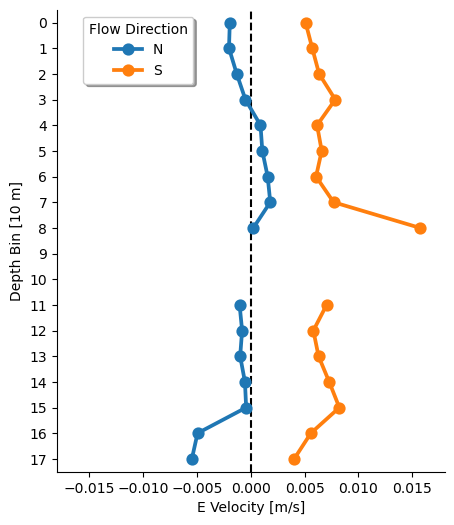

In [271]:
# 10 m depth bins
data_ew_conditional['depth_bin'] = (data_ew_conditional['depth'] // 10).astype(int)

fig, ax = plt.subplots(figsize=(5, 6))

ax.axvline(0, color='black', ls='--')
sns.pointplot(data_ew_conditional.query("depth_bin != 9"), x='vel', y='depth_bin', orient='h', order=np.arange(18),
              hue='flow_dir', hue_order=['N', 'S'], errorbar=('se', 1.96), ax=ax)

ax.set_xlabel('E Velocity [m/s]')
ax.set_ylabel('Depth Bin [10 m]')
ax.set_xlim(-0.018, 0.018)

ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Flow Direction', shadow=True, loc='upper left', bbox_to_anchor=(0.05, 1))

plt.savefig('../gallery/dd/2025_12_11/ew_conditional_ns.png', bbox_inches='tight')
plt.show()